In [1]:
using Plots
using JSON

function readJSON(_file::String)
    println(".read")
    open(_file,"r") do f
        data = JSON.parse(f)
        if  haskey(data,"coords") & haskey(data, "N") & haskey(data, "h") & haskey(data, "radius") &
            haskey(data, "mass") & haskey(data, "kspr") & haskey(data, "connection_map") & 
            haskey(data, "forces") & haskey(data, "connection_map") & haskey(data, "restrs")

            N = convert(Int64,data["N"])
            h = convert(Float64,data["h"])
            r = convert(Float64,data["radius"])/100
            mass = convert(Float64,data["mass"])
            kspr = convert(Float64,data["kspr"])

            ne = size(data["coords"])[1]

            conect = zeros(Int64, ne, 5)

            F =  Array{Float64}(undef,ne*2,1)

            restrs = Array{Int64}(undef,ne*2,1)

            x0 = Array{Float64}(undef,ne,1)
            y0 = Array{Float64}(undef,ne,1)

            for i=1:ne
                x0[i] = convert(Float64,data["coords"][i][1])/100
                y0[i] = convert(Float64,data["coords"][i][2])/100

                for j=1:5
                    conect[i,j] = convert(Int64, data["connection_map"][i][j])
                end

            end

            for i=1:2*ne
                F[i] = convert(Float64,data["forces"][i])
                restrs[i] = convert(Int64,data["restrs"][i])
            end

        end

        return N, h, ne, x0, y0, r, mass, kspr, F, restrs, conect
    end
end

function findIndex(F)
    count = 0
    sum = 0
    for i=1:size(F)[1]
        if (F[i] != 0)
            sum += i
            count += 1
        end
    end

    resp = convert(Int64, (sum/count))

    if (count%2 == 0)
        return resp + 1
    end
    return resp
end

function main(_file::String)
    println(".DEM")

    N, h, ne, x0, y0, raio, mass, kspr, F, restrs, conect = readJSON(_file)
    ne = convert(Int64, length(conect)/5)
    print(ne)
    ndofs = 2*ne

    u = zeros(Float64,ndofs,1)
    v = zeros(Float64,ndofs,1)
    a = zeros(Float64,ndofs,1)
    res = zeros(Float64,N)

    fi = zeros(Float64,ndofs,1)
    #@show fi
    a .= (F .- fi)./mass    
    for i = 1:N
        v .+= a .* (0.5*h)
        u .+= v .* h
        # contato
        fi .= 0.0
        for j = 1:ne
            if (restrs[2*j-1] == 1 && restrs[2*j] == 1)
                u[2*j-1] = 0.0
                u[2*j] = 0.0
            else
                xj = x0[j] + u[2*j-1]
                yj = y0[j] + u[2*j]
                for index = 1:conect[j,1]
                    k = conect[j,index+1]
                    xk = x0[k] + u[2*k-1]
                    yk = y0[k] + u[2*k]
                    dX = xj-xk
                    dY = yj-yk
                    di = sqrt(dX*dX+dY*dY)
                    d2 = (di - 2*raio)
                    dx = d2*dX/di
                    dy = d2*dY/di
                    fi[2*j-1] += kspr*dx
                    fi[2*j] += kspr*dy
                end
            end
        end
        a .= (F .- fi)./mass
        v .+= a .* (0.5*h)
        # plot
        res[i] = u[findIndex(F)]
    end

    x = 1:N

    return x, res
end

x, res = main("med.json")

.DEM
.read


84

(1:600, [1.0191082802547773e-10, 4.0328128391102977e-10, 8.913986411588303e-10, 1.5462797841395584e-9, 2.3423432789817888e-9, 3.2504967725305574e-9, 4.240422798371653e-9, 5.282831242561475e-9, 6.35145846873877e-9, 7.42462963595812e-9  …  7.115558537321649e-8, 6.991992375448464e-8, 6.871097041560926e-8, 6.75350343895467e-8, 6.63992393605297e-8, 6.531095737327392e-8, 6.427716152945081e-8, 6.330375119837614e-8, 6.239490269861901e-8, 6.155249559403006e-8])

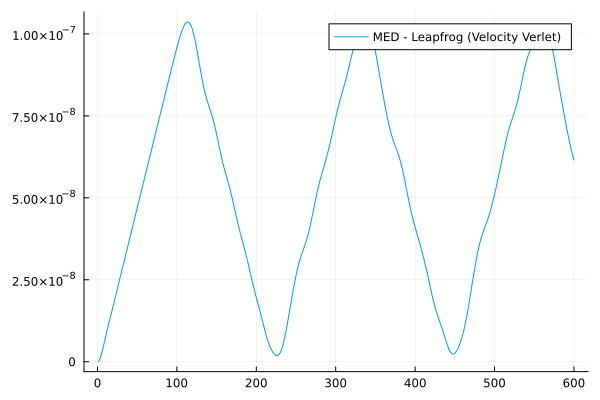

In [3]:
plot(x,res, label="MED - Leapfrog (Velocity Verlet)")